# Cycle GAN

In [2]:
import pandas as pd
import glob
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import utils
from torch.utils.data import DataLoader
import tqdm as tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

/home/johann/anaconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset
### Load data from csv

In [3]:
# load all csv files in a folder and return a single dataframe
path = "/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports_not_all_the_data/constant_speed_interventions/" # time: ~ 19 sec
path_1 = "/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/csv_export_files_alle_Daten/csv_export_files/Data_split_1"  # time: ~ 35 sec
path_2 = "/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/csv_export_files_alle_Daten/csv_export_files/Data_split_2"
path_3 = "/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/csv_export_files_alle_Daten/csv_export_files/Data_split_3"
path_4 = "/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/csv_export_files_alle_Daten/csv_export_files/Data_split_4"

def load_csv(path):
    all_files = glob.glob(path + "/*.csv")
    li = []
    for filename in all_files:
        df = pd.read_csv(filename, sep=";")
        li.append(df)
    frame = pd.concat(li, axis=0, ignore_index=True)
    return frame

df = load_csv(path)
#print(df.shape)
#print(type(df)) # <class 'pandas.core.frame.DataFrame'>

In [4]:
df = df.drop(columns=['Time',  'RVP', 'PaP', 'PaQ', 'ECGcond', 'Looperkennung', 'Extrasystolen', 'Ansaugphase', 'ECG', 'ECGcond', 'LVV1', 'LVV2', 
                      'LVV3', 'LVV4', 'LVV5', 'RVV1', 'RVV2', 'RVV3', 'RVV4', 'RVV5', 'Versuchsdatum', 'rep_an', 'rep_sect', 'contractility', 
                      'preload', 'afterload', 'controller'])
print(df.shape)
# remove Nan values
df = df.dropna()
print(df.shape)
# select only rows where 'Phasenzuordnung' is 1
df = df.loc[df['Phasenzuordnung'] == 1]

print(df.shape)  

(8120300, 13)
(8072873, 13)
(720947, 13)


In [ ]:
df_1 = load_csv(path_1)
# drop columns that are not needed
df_1 = df_1.drop(columns=['Time',  'RVP', 'PaP', 'PaQ', 'ECGcond', 'Looperkennung', 'Extrasystolen', 'Ansaugphase', 'ECG', 'ECGcond', 'LVV1', 'LVV2', 
                      'LVV3', 'LVV4', 'LVV5', 'RVV1', 'RVV2', 'RVV3', 'RVV4', 'RVV5', 'Versuchsdatum', 'rep_an', 'rep_sect', 'contractility', 
                      'preload', 'afterload', 'controller'])


df_2 = load_csv(path_2)
df_2 = df_2.drop(columns=['Time',  'RVP', 'PaP', 'PaQ', 'ECGcond', 'Looperkennung', 'Extrasystolen', 'Ansaugphase', 'ECG', 'ECGcond', 'LVV1', 'LVV2', 
                      'LVV3', 'LVV4', 'LVV5', 'RVV1', 'RVV2', 'RVV3', 'RVV4', 'RVV5', 'Versuchsdatum', 'rep_an', 'rep_sect', 'contractility', 
                      'preload', 'afterload', 'controller'])



df_3 = load_csv(path_3)
df_3 = df_3.drop(columns=['Time',  'RVP', 'PaP', 'PaQ', 'ECGcond', 'Looperkennung', 'Extrasystolen', 'Ansaugphase', 'ECG', 'ECGcond', 'LVV1', 'LVV2', 
                      'LVV3', 'LVV4', 'LVV5', 'RVV1', 'RVV2', 'RVV3', 'RVV4', 'RVV5', 'Versuchsdatum', 'rep_an', 'rep_sect', 'contractility', 
                      'preload', 'afterload', 'controller'])



df_4 = load_csv(path_4)
df_4 = df_4.drop(columns=['Time',  'RVP', 'PaP', 'PaQ', 'ECGcond', 'Looperkennung', 'Extrasystolen', 'Ansaugphase', 'ECG', 'ECGcond', 'LVV1', 'LVV2', 
                      'LVV3', 'LVV4', 'LVV5', 'RVV1', 'RVV2', 'RVV3', 'RVV4', 'RVV5', 'Versuchsdatum', 'rep_an', 'rep_sect', 'contractility', 
                      'preload', 'afterload', 'controller'])

df = pd.concat([df_1, df_2, df_3, df_4], axis=0, ignore_index=True)

#print(df.shape) # (60471400, 13)
df = df.dropna()
#print(df.shape) # 60221949, 13)

# select only rows where 'Phasenzuordnung' is 1
df = df.loc[df['Phasenzuordnung'] == 1]

print(df.shape)
print(type(df)) # (7508420, 13) # Time: ~ 4m 10 sec

## Preprocesssing
### Removing strings from the data

In [5]:
# convert to numpy array
df_cols = df_cols = ['LVtot_kalibriert', 'LVP', 'AoP', 'AoQ', 'RVtot_kalibriert', 'VADspeed', 'VadQ', 'VADcurrent', 'Phasenzuordnung', 
           'LVtot', 'RVtot', 'animal', 'intervention']

df = df.to_numpy()
print(df.shape)
print(type(df))

# iterate over rows and columns of numpy array
for row in range(df.shape[0]):
    for col in range(df.shape[1]):
        # if type is string, convert to float
        if type(df[row, col]) == str:
            #arr[row, col] = float(arr[row, col]) # ValueError: could not convert string to float: ' 98.16152 [ml]'
            # remove the string '[ml]' and convert to float
            #print(arr[row, col])
            df[row, col] = df[row, col].replace('[ml]', '')
            df[row, col] = df[row, col].replace('[mmHg]', '')
            df[row, col] = df[row, col].replace('[L/min]', '')
            df[row, col] = df[row, col].replace('[rpm]', '')
            df[row, col] = df[row, col].replace('[A]', '')
            df[row, col] = df[row, col].replace('[mL]', '')
            df[row, col] = float(df[row, col])

# convert back to dataframe
df = pd.DataFrame(df, columns=df_cols)
print(df.shape)  # Time ~ 23 sec
print(type(df))  # <class 'pandas.core.frame.DataFrame'>

(720947, 13)
<class 'numpy.ndarray'>
(720947, 13)
<class 'pandas.core.frame.DataFrame'>


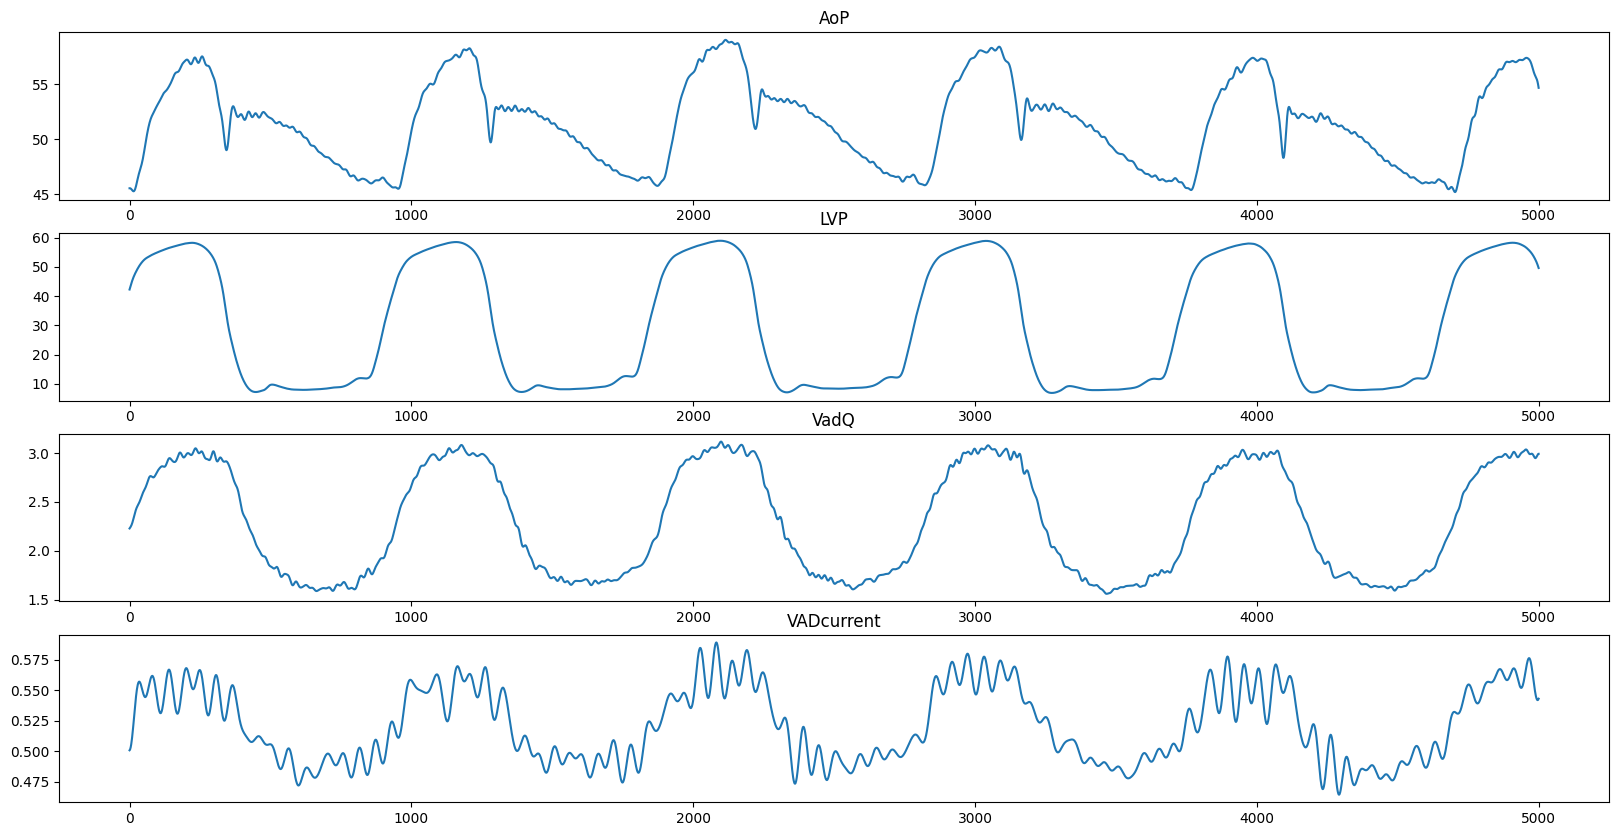

In [6]:
#plot AoP, LVP, VadQ, VADcurrent in different plots
fig, axs = plt.subplots(4, 1, figsize=(20, 10))
axs[0].plot(df['AoP'][:5000])
axs[0].set_title('AoP')
axs[1].plot(df['LVP'][:5000])
axs[1].set_title('LVP')
axs[2].plot(df['VadQ'][:5000])
axs[2].set_title('VadQ')
axs[3].plot(df['VADcurrent'][:5000])
axs[3].set_title('VADcurrent')
plt.show()

### Subsample the data by the factor 10

In [7]:
# columns = ['LVtot_kalibriert', 'LVP', 'AoP', 'AoQ', 'RVtot_kalibriert', 'VADspeed', 'VadQ', 'VADcurrent', 'LVtot', 'RVtot', 'intervention',
#                 'Phasenzuordnung', 'animal'] 

columns = ['LVtot_kalibriert', 'LVP', 'AoP', 'AoQ', 'RVtot_kalibriert', 'VADspeed', 'VadQ', 
            'VADcurrent', 'Phasenzuordnung', 'LVtot', 'RVtot', 'animal', 'intervention']

arr = df.to_numpy()

def groupedAvg(myArray, N=10):
    result = np.cumsum(myArray, 0)[N-1::N]/float(N)
    result[1:] = result[1:] - result[:-1]
    return result

print(arr.shape)
arr = groupedAvg(arr, N=10)
print(arr.shape)


df = pd.DataFrame(arr, columns=columns)
#print(type(df_train), type(df_test))

# add column names to df_train and df_test
#df.columns = columns

# colums animal and intervention should be integers
df['animal'] = df['animal'].astype(int)
df['intervention'] = df['intervention'].astype(int)
print(df.head())

(720947, 13)
(72094, 13)
   LVtot_kalibriert        LVP        AoP       AoQ  RVtot_kalibriert  \
0        136.945911  43.733307  45.496507  0.239615         80.628530   
1        136.119152  46.546286  45.325503  0.378293         79.387186   
2        135.101828  48.622489  45.933186  0.812218         77.954111   
3        133.813449  50.307336  46.975143  1.447258         76.520033   
4        132.431854  51.633226  47.927148  2.155005         75.424020   

    VADspeed      VadQ  VADcurrent  Phasenzuordnung      LVtot      RVtot  \
0  3210.4180  2.250695    0.504613              1.0  159.38540  150.44051   
1  3208.6189  2.335473    0.524283              1.0  158.61787  149.52167   
2  3207.3879  2.432488    0.547356              1.0  157.67343  148.63791   
3  3205.2133  2.495627    0.556459              1.0  156.47734  147.50659   
4  3207.1537  2.570268    0.550951              1.0  155.19471  146.72090   

   animal  intervention  
0      11            10  
1      11            

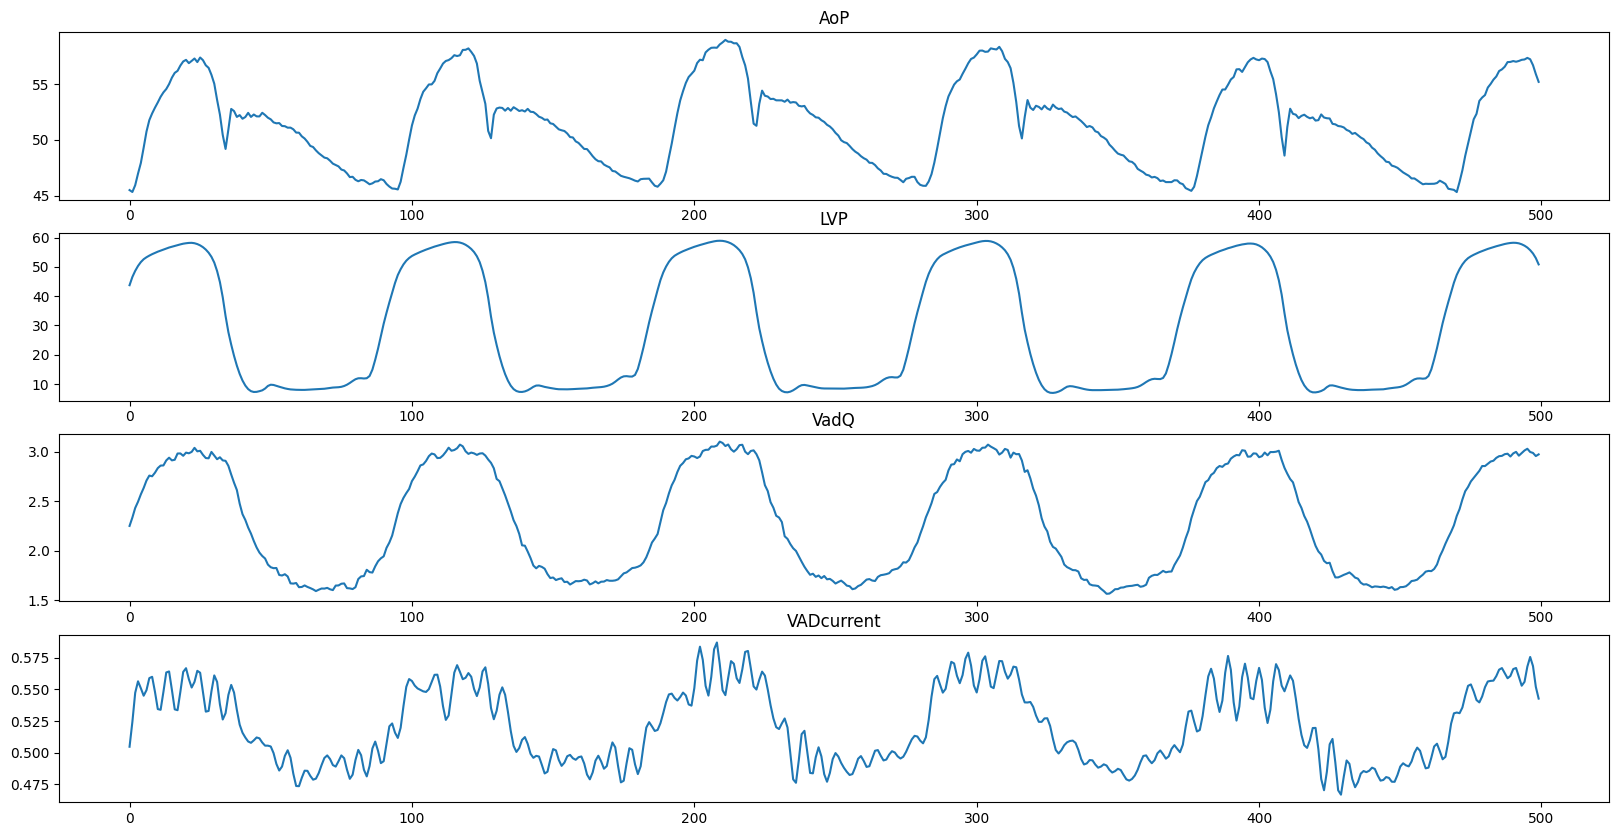

In [8]:
#plot AoP, LVP, VadQ, VADcurrent in different plots
fig, axs = plt.subplots(4, 1, figsize=(20, 10))
axs[0].plot(df['AoP'][:500])
axs[0].set_title('AoP')
axs[1].plot(df['LVP'][:500])
axs[1].set_title('LVP')
axs[2].plot(df['VadQ'][:500])
axs[2].set_title('VadQ')
axs[3].plot(df['VADcurrent'][:500])
axs[3].set_title('VADcurrent')
plt.show()

### Normalize the data

In [9]:
# intervntion, Phasenzuordnung and animal should be in another dataframe before the data is normalized
df_IPA = df[['intervention', 'Phasenzuordnung', 'animal']]

# drop columns in original dataframe
df = df.drop(columns=['intervention', 'Phasenzuordnung', 'animal'])

In [10]:
# The data has to be array-like
df_cols = ['LVtot_kalibriert', 'LVP', 'AoP', 'AoQ', 'RVtot_kalibriert', 'VADspeed', 'VadQ', 'VADcurrent', 'LVtot', 'RVtot']
df = df.to_numpy()

# scale the data
scaler = StandardScaler()
scaler.fit(df)
transformed_data = scaler.transform(df)

df = pd.DataFrame(transformed_data, columns=df_cols)
print(df.shape)
# concatenate df and df_IPA
df = pd.concat([df, df_IPA], axis=1)
print(df.shape)
#print(df.head())

(72094, 10)
(72094, 13)


### Visualize all the data

### Nicht invasive Messgroessen: 
#### Pumpenfluss, Pumpenstrom, Aortendruck , Ventrikeldruck 

***AoP*** = Drucksignal Hauptschlagader = Aortendruck

***LVP*** = Ventrikeldruck links = Drucksignal der linken Herzkammer

***VADQ*** = Fluss durch VAD (VAD = Ventrikular assistance device = Pumpe) = Pumpenfluss

***VadCurrent*** = VAD Strom [A] – Pumpemstrom in Ampere

#### Diese hier sind eventuell ebenfalls nicht invasiv

***AoQ*** = Flusssignal Hauptschlagader/ Aorta [l/min] - Aortenfluss

***VADspeed*** = VAD Geschwindigkeit [rpm] (rpm = drehzahl). Kann man nutzen

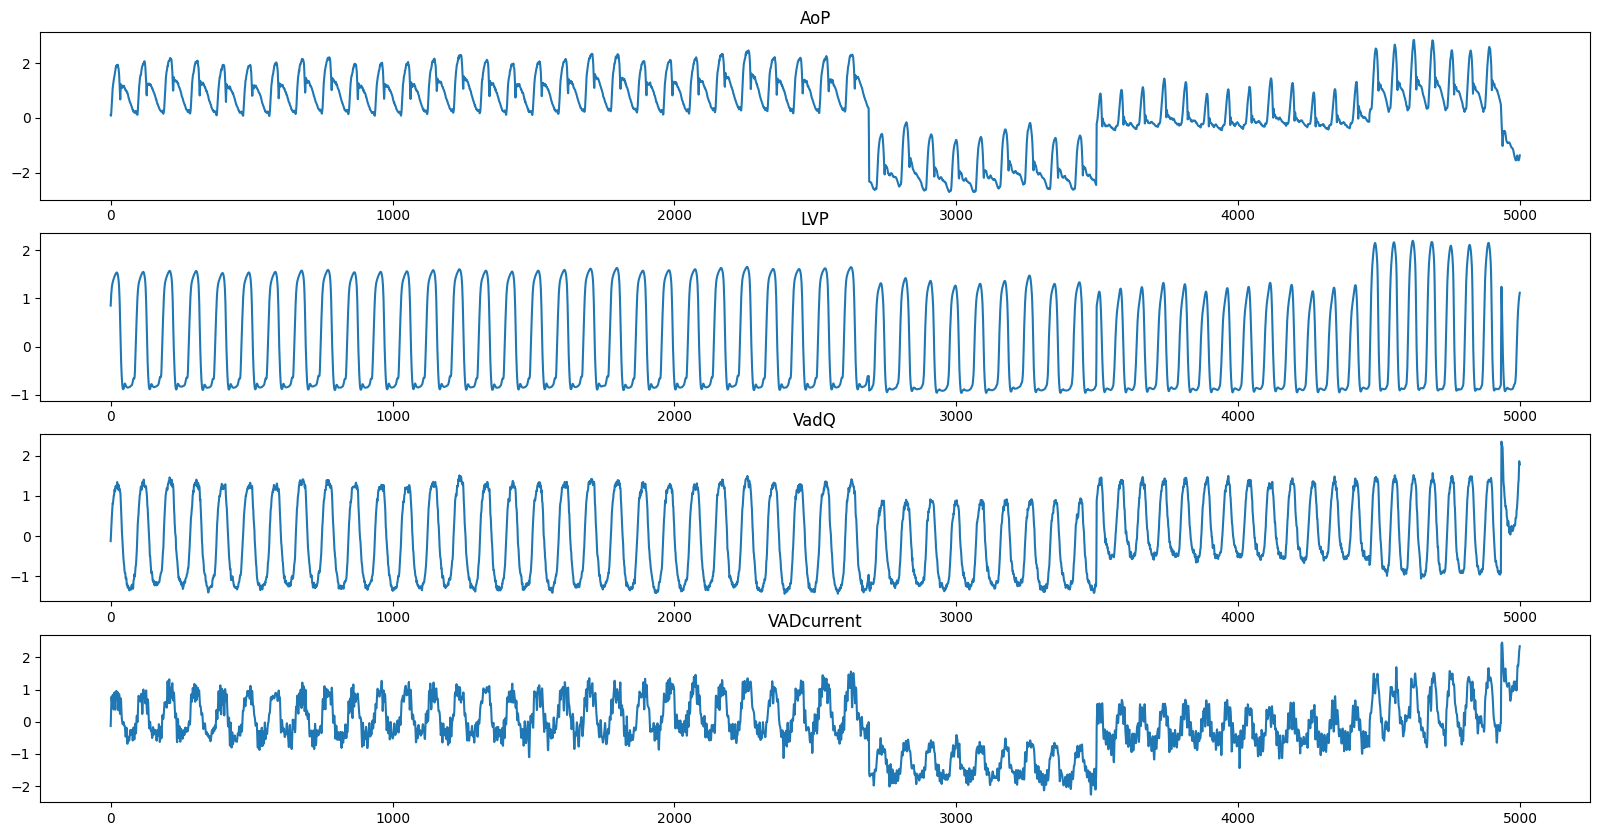

In [11]:
#plot AoP, LVP, VadQ, VADcurrent in different plots
fig, axs = plt.subplots(4, 1, figsize=(20, 10))
axs[0].plot(df['AoP'][:5000])
axs[0].set_title('AoP')
axs[1].plot(df['LVP'][:5000])
axs[1].set_title('LVP')
axs[2].plot(df['VadQ'][:5000])
axs[2].set_title('VadQ')
axs[3].plot(df['VADcurrent'][:5000])
axs[3].set_title('VADcurrent')
plt.show()

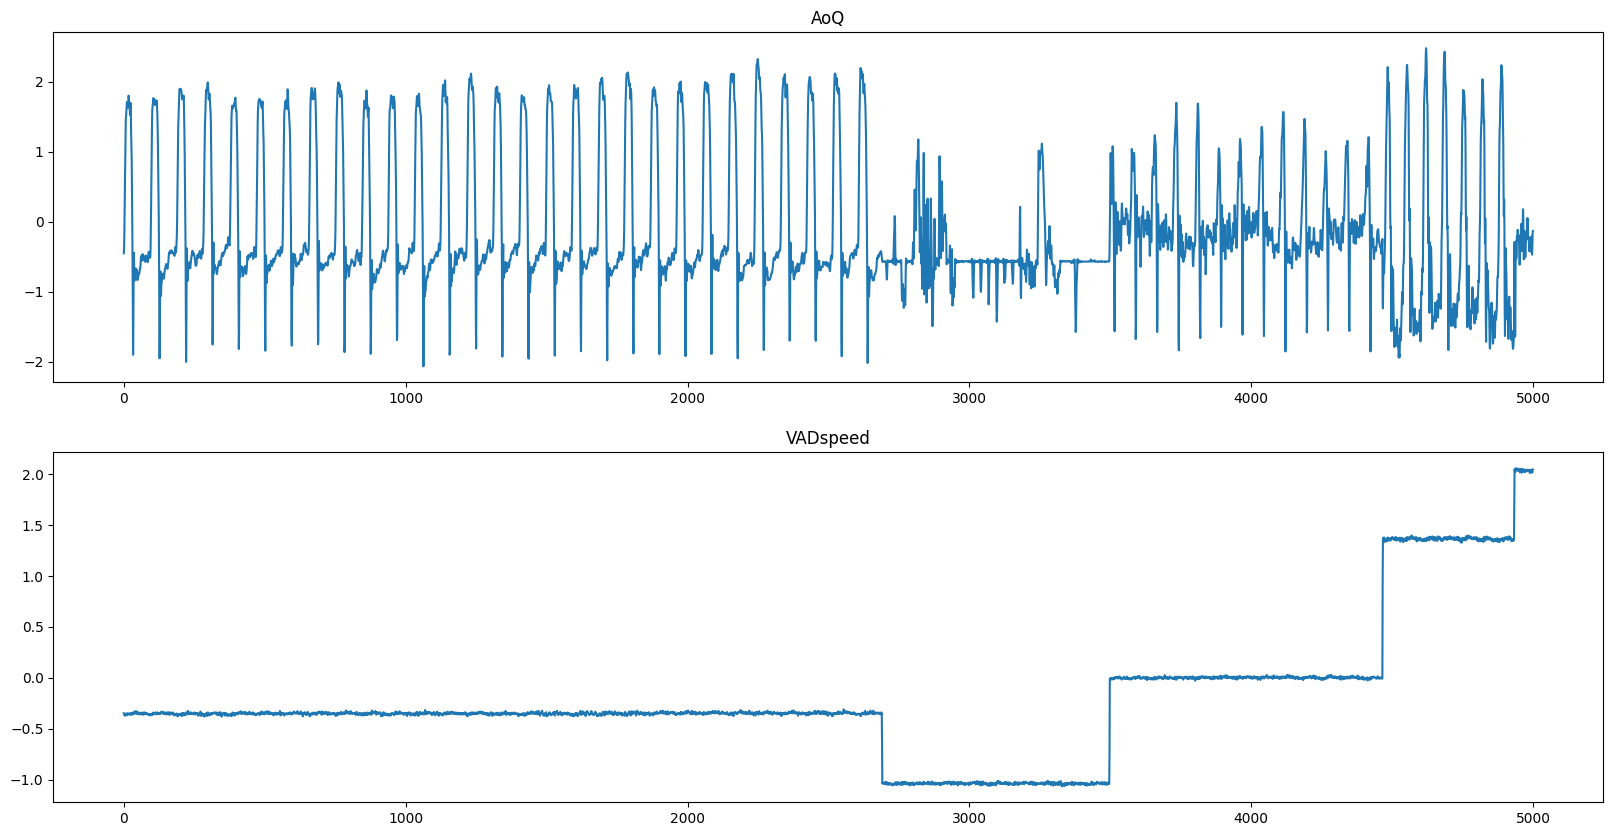

In [12]:
# plot AoQ and VADspeed in differents plots
fig, axs = plt.subplots(2, 1, figsize=(20, 10))
axs[0].plot(df['AoQ'][:5000])
axs[0].set_title('AoQ')
axs[1].plot(df['VADspeed'][:5000])
axs[1].set_title('VADspeed')
plt.show()

 ### Invasive Regelgroessen: 
#### Ventrikelvolumen, Schlagarbeit

***LVtot*** = unkalibriertes Volumensignal der linken Herzkammer [ml] (Ventrikelvolumen)

***RVtot*** = unkalibriertes Volumensignal der rechten Herzkammer [ml] (Ventrikelvolumen der rechten Herzkammer. Erstmal das der lnken anschauen)

***LVtot_kalibriert*** = kalibriertes Ventrikelvolumen

***RVtot_kalibriert*** = Kalibriertes Volumensignal der rechten Herzkammer = kalibriertes Ventrikelvolumen (wenn vorhanden – kalibriert nutzen)

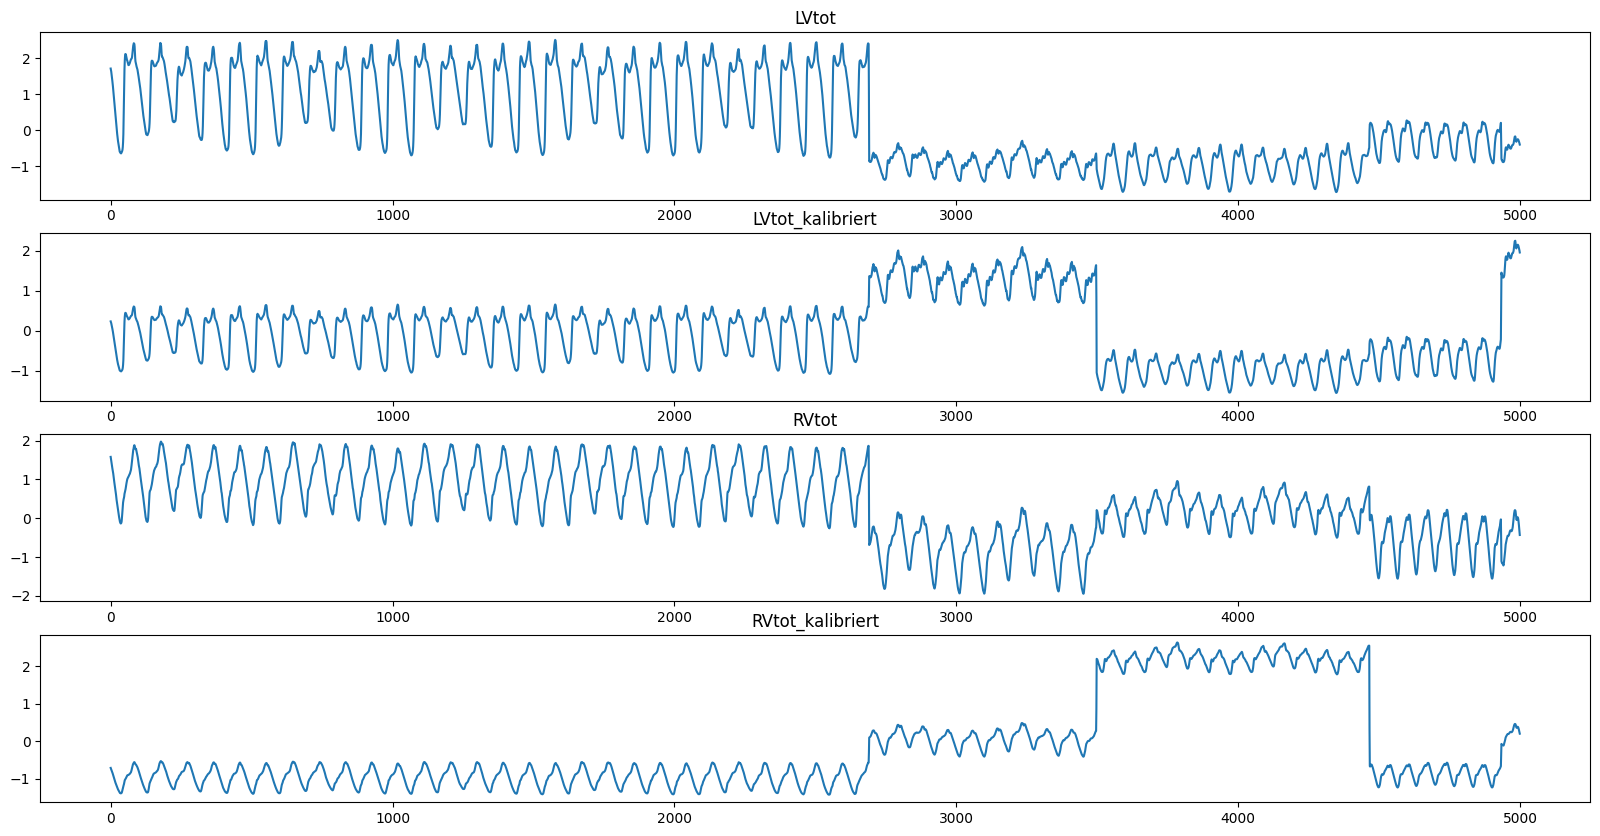

In [13]:
# plot LVtot, LVtot_kalibriert, RVtot, RVtot_kalibriert in different plots
fig, axs = plt.subplots(4, 1, figsize=(20, 10))
axs[0].plot(df['LVtot'][:5000])
axs[0].set_title('LVtot')
axs[1].plot(df['LVtot_kalibriert'][:5000])
axs[1].set_title('LVtot_kalibriert')

axs[2].plot(df['RVtot'][:5000])
axs[2].set_title('RVtot')
axs[3].plot(df['RVtot_kalibriert'][:5000])
axs[3].set_title('RVtot_kalibriert')
plt.show()

### Andere relevante Variablen

***intervention*** = Gibt an welche Intervention im aktuellen Ausschnitt durchgeführt wurde: 1 = Vorlastreduktion (Googlen), 2 & 3 = Nachlasterhöhung (Googlen) , 4 = Speedramp (Pumpenstrom angehoben)

***Phasenzuordnung***

***animal***

In [14]:
#plot intervention, Phasenzuordnung and animal in different plots
# fig, axs = plt.subplots(3, 1, figsize=(20, 10))
# axs[0].plot(df['intervention'][:5000])
# axs[0].set_title('intervention')
# axs[1].plot(df['Phasenzuordnung'][:5000])
# axs[1].set_title('Phasenzuordnung')
# axs[2].plot(df['animal'][:5000])
# axs[2].set_title('animal')
# plt.show()

### Split data into train and test split

In [15]:
# hom many different intervention ids are there?
print('\nDifferent interventions: \n',df['intervention'].unique())

# hom many different animal ids are there?
print('\nDifferent animal IDs: \n',len(df['animal'].unique()))

# remove animals with less than 10 data points
df = df.groupby('animal').filter(lambda x: len(x) > 10)
print('\nDifferent animal IDs after removing those with less than 10 data points: \n',len(df['animal'].unique()))

# length of data per animal
#print(df.groupby('animal').size())

all_animals = df['animal'].unique()
# pick 2 random animals for test data
test_animals = df['animal'].sample(n=1, random_state=1).unique()

# remove test animals from train animals
train_animals =  [x for x in all_animals if x not in test_animals]

print('\nTest animals:', test_animals)
# test data
df_test = df[df['animal'].isin(test_animals)]

# train dataframe with only animals from train_animals
df_train = df[df['animal'].isin(train_animals)]
print('\nDifferent animal IDs after removing those that are in the test dataset: \n',len(df_train['animal'].unique()))


print('\nTrain data shape:', df_train.shape)
print('\nTest data shape:', df_test.shape)

#print('Unique animals in df_train: ',df_train['animal'].unique())
#print('Unique animals in df_test: ',df_test['animal'].unique())

# lengt of df_train
print('\nThe test dataset is {} percent of the whole data: '.format((len(df_test)/(len(df_train) + len(df_test))) * 100))


Different interventions: 
 [10  7  3  1  4  2  5  6]

Different animal IDs: 
 10

Different animal IDs after removing those with less than 10 data points: 
 6

Test animals: [19]

Different animal IDs after removing those that are in the test dataset: 
 5

Train data shape: (64342, 13)

Test data shape: (7736, 13)

The test dataset is 10.73281722578318 percent of the whole data: 


In [16]:
# create gen_dataset which is a part of the test dataset
#df_gen = df_test.sample(frac=0.01, random_state=1)
#print('\nGen data shape:', df_gen.shape)
df_gen = df_test

### Dataset loader

In [17]:
# Train Dataset includes data from multiple animals

class TrainDataset(Dataset):
    def __init__(self, signal_A, signal_B, df):
        self.df = df
        self.signal_A = self.df[signal_A]
        self.signal_B = self.df[signal_B]

        # only data from a single animal per batch 
        for animal in self.df['animal'].unique():
            df_single_animal = self.df[self.df['animal'] == animal]
            
            # length should be modulo 256 = 0
            df_single_animal = df_single_animal.iloc[:-(len(df_single_animal) % 256), :]
            # creating tensor from df 
            tensor_A = torch.tensor(df_single_animal[signal_A].values)
            tensor_B = torch.tensor(df_single_animal[signal_B].values)

            # split tensor into tensors of size 256
            tensor_A = tensor_A.split(256)  # tensor shape (256, 1) 
            tensor_B = tensor_B.split(256)       

            # stack tensors
            stack_A = torch.stack(tensor_A).unsqueeze(1) 
            stack_B = torch.stack(tensor_B).unsqueeze(1) 
            #print(stack_A.shape, stack_B.shape)
            
            if animal == self.df['animal'].unique()[0]:
                # add stack
                self.tensor_A = stack_A
                self.tensor_B = stack_B
                
            else:
                # add stack
                self.tensor_A = torch.cat((self.tensor_A, stack_A), 0)
                self.tensor_B = torch.cat((self.tensor_B, stack_B), 0)
          

    def __len__(self):
        # signal_A and signal_B should have the same length
        return len(self.tensor_A)

    def __getitem__(self, index):
        # return the signal at the given index  # add data augmentation?
        return self.tensor_A[index], self.tensor_B[index]

In [18]:
# Test Dataset includes data from a single animal

class TestDataset(Dataset):
    def __init__(self, signal_A, signal_B, df):
        self.df = df
        self.signal_A = self.df[signal_A]
        self.signal_B = self.df[signal_B]

        # length should be modulo 256 = 0
        self.df = self.df.iloc[:-(len(self.df) % 256), :]
        
        # creating tensor from df 
        tensor_A = torch.tensor(self.df[signal_A].values)
        tensor_B = torch.tensor(self.df[signal_B].values)

        # split tensor into tensors of size 256
        tensor_A = tensor_A.split(256)  # tensor shape (256, 1) 
        tensor_B = tensor_B.split(256)       

        # stack tensors
        self.tensor_A = torch.stack(tensor_A).unsqueeze(1) 
        self.tensor_B = torch.stack(tensor_B).unsqueeze(1) 
        # print(self.tensor_A.shape, self.tensor_A.shape)


    def __len__(self):
        # signal_A and signal_B should have the same length
        return len(self.tensor_A)

    def __getitem__(self, index):
        # return the signal at the given index  # add data augmentation?
        return self.tensor_A[index], self.tensor_B[index]

In [19]:
SIG_A =  "VadQ" # "LVP"  
SIG_B =  "LVtot_kalibriert" 

# train_dataset = TrainDataset(signal_A=SIG_A, signal_B=SIG_B, df=df_train)
train_dataset = TestDataset(signal_A=SIG_A, signal_B=SIG_B, df=df_train)
test_dataset = TestDataset(signal_A=SIG_A, signal_B=SIG_B, df=df_test)

# Data loader
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=10, pin_memory=True,)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=True, pin_memory=True,)

# length of train and test dataset
print(len(train_dataset), len(test_dataset))

251 30


### Generator

In [20]:
def double_conv_pad(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1, padding_mode='zeros'),
        # nn.InstanceNorm1d(out_channels),  # InstanceNorm1d is not working
        # nn.BatchNorm1d(out_channels),  # BatchNorm1d is not working
        nn.LeakyReLU(inplace=True),
        #nn.BatchNorm1d(out_channels),
        nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1, padding_mode='zeros'),
        #nn.InstanceNorm1d(out_channels), # InstanceNorm1d is not working
        # nn.BatchNorm1d(out_channels),  # BatchNorm1d is not working
        nn.LeakyReLU(inplace=True)
        #nn.BatchNorm1d(out_channels)
    ) 

class UnetGenerator(nn.Module):
    def __init__(self):
        super(UnetGenerator, self).__init__()
        self.maxpool = nn.MaxPool1d(2)

        self.down_conv1 = double_conv_pad(1, 32) 
        self.down_conv2 = double_conv_pad(32, 64) 
        self.down_conv3 = double_conv_pad(64, 128)
        self.down_conv4 = double_conv_pad(128, 256)

        self.up_trans1 = nn.ConvTranspose1d(256, 128, kernel_size=2, stride=2)
        self.up_conv1 = double_conv_pad(256, 128)
        self.up_trans2 = nn.ConvTranspose1d(128, 64, kernel_size=2, stride=2)
        self.up_conv2 = double_conv_pad(128, 64)
        self.up_trans3 = nn.ConvTranspose1d(64, 32, kernel_size=2, stride=2)
        self.up_conv3 = double_conv_pad(64, 32)

        self.out = nn.Conv1d(32, 1, kernel_size=1)

    def forward(self, input):
        
        # batch_size, channels, tensor_size
        # encoder input -> 1, 1, 572
        #print(input.size())
        x1 = self.down_conv1(input)  # 
        #print(x1.size())  
        x2 = self.maxpool(x1) 
        #print(x2.size())
        x3 = self.down_conv2(x2)  #
        #print(x3.size())
        x4 = self.maxpool(x3) 
        #print(x4.size()) 
        x5 = self.down_conv3(x4)  #
        #print(x5.size()) 
        x6 = self.maxpool(x5)
        #print(x6.size())  
        x7 = self.down_conv4(x6)
        #print(x7.size())

        # decoder
        x = self.up_trans1(x7)
        x = self.up_conv1(torch.cat([x, x5], 1))
        x = self.up_trans2(x)
        x = self.up_conv2(torch.cat([x, x3], 1))
        x = self.up_trans3(x)
        x = self.up_conv3(torch.cat([x, x1], 1))
        x = self.out(x)
        #print(x.size())
        return x
    
x = torch.rand(1,1,256)
model = UnetGenerator()
#print(model(x))  # The model outputs a tensor of size 1, 1, 256, perfect
print(model(x).shape)

torch.Size([1, 1, 256])


### Discriminator

In [21]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.InstanceNorm1d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.block(x)
    
#x = torch.randn((1, 1, 128))
#block = Block(1, 32, 2)
#print(block(x).shape)

class AP_Discriminator(nn.Module):
    def __init__(self, in_channels=1, out_channels=[32,64,128,256]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv1d(in_channels, out_channels[0], kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
        )
        layers = []
        in_channels = out_channels[0]
        for out_channel in out_channels[1:]:
            layers.append(Block(in_channels, out_channel, stride=1 if out_channel == 256 else 2))
            in_channels = out_channel

        layers.append(nn.Conv1d(out_channels[-1], 1, kernel_size=3, stride=1, padding=1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial(x)
        return torch.sigmoid(self.model(x))
    
x = torch.randn((1, 1, 256))
disc = AP_Discriminator()
print(disc(x).shape)

torch.Size([1, 1, 32])


### Train model

In [39]:
# config

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 512  #1024 didsn't work so well
LEARNING_RATE = 1e-3  # 1e-5 was too small for 'LVtot_kalibriert' and 'LVtot'
# LAMBDA_IDENTITY = 0.1
LAMBDA_CYCLE = 1.0 # try out different values
NUM_WORKERS = 4
NUM_EPOCHS = 1000 # 2000
LR_DECAY_AFTER_EPOCH = 500  # if LR_DECAY_AFTER_EPOCH = NUM_EPOCHS -> no decay
GENERATION_AFTER_EPOCH = NUM_EPOCHS # number of epochs after which the model generates a sample
LAMBDA_SUPERVISED = 1.0
LOAD_MODEL = False
SAVE_MODEL = False
SIG_A = "AoP" # "VADcurrent" # "VadQ" # "AoP" # "LVP"   
SIG_B = "LVtot_kalibriert" 
CHECKPOINT_GEN_A2B = "Checkpoints/Generated_data/gen_{}.pth.tar".format(SIG_B)
CHECKPOINT_GEN_B2A = "Checkpoints/Generated_data/gen_{}.pth.tar".format(SIG_A)
CHECKPOINT_DISC_A =  "Checkpoints/Generated_data/disc{}.pth.tar".format(SIG_A)
CHECKPOINT_DISC_B =  "Checkpoints/Generated_data/disc{}.pth.tar".format(SIG_B)


/tmp/ipykernel_4230/1510098161.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(df_train[SIG_A][:1000], label= SIG_A)
/tmp/ipykernel_4230/1510098161.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(df_train[SIG_B][:1000], label= SIG_B)


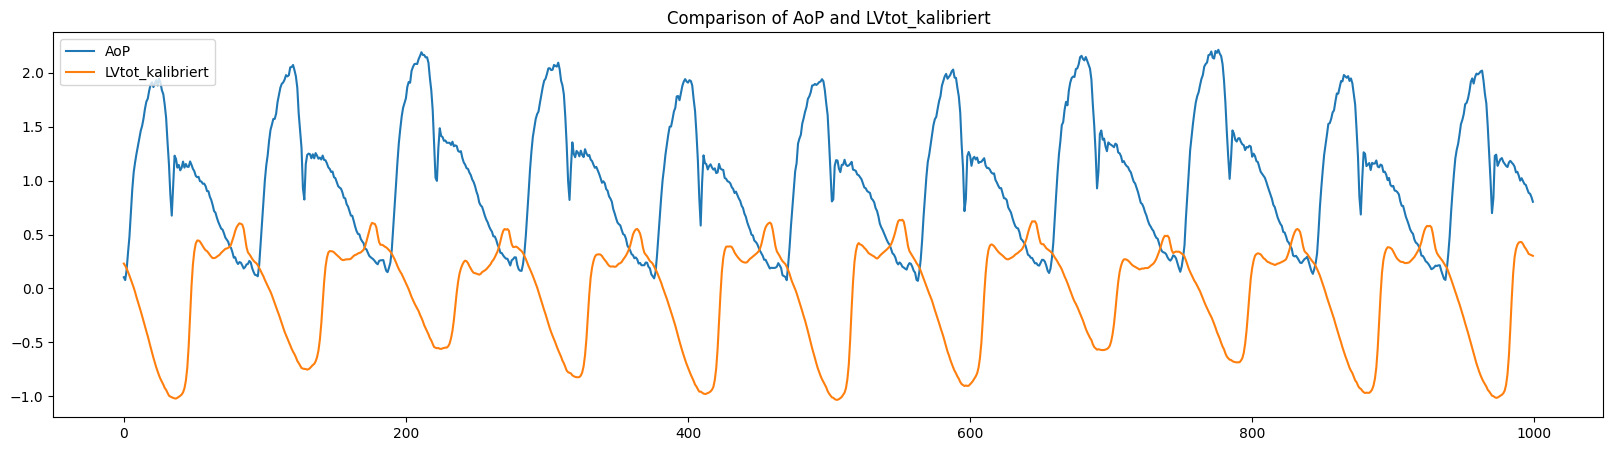

In [40]:
# Visualize the data we want to generate
plt.figure(figsize=(20, 5))
plt.plot(df_train[SIG_A][:1000], label= SIG_A)
plt.plot(df_train[SIG_B][:1000], label= SIG_B)
plt.title('Comparison of {} and {}'.format(SIG_A, SIG_B))
plt.legend()
plt.show()

/tmp/ipykernel_4230/3398170213.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(df_train[SIG_A][5000:6000], label= SIG_A)
/tmp/ipykernel_4230/3398170213.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(df_train[SIG_B][5000:6000], label= SIG_B)


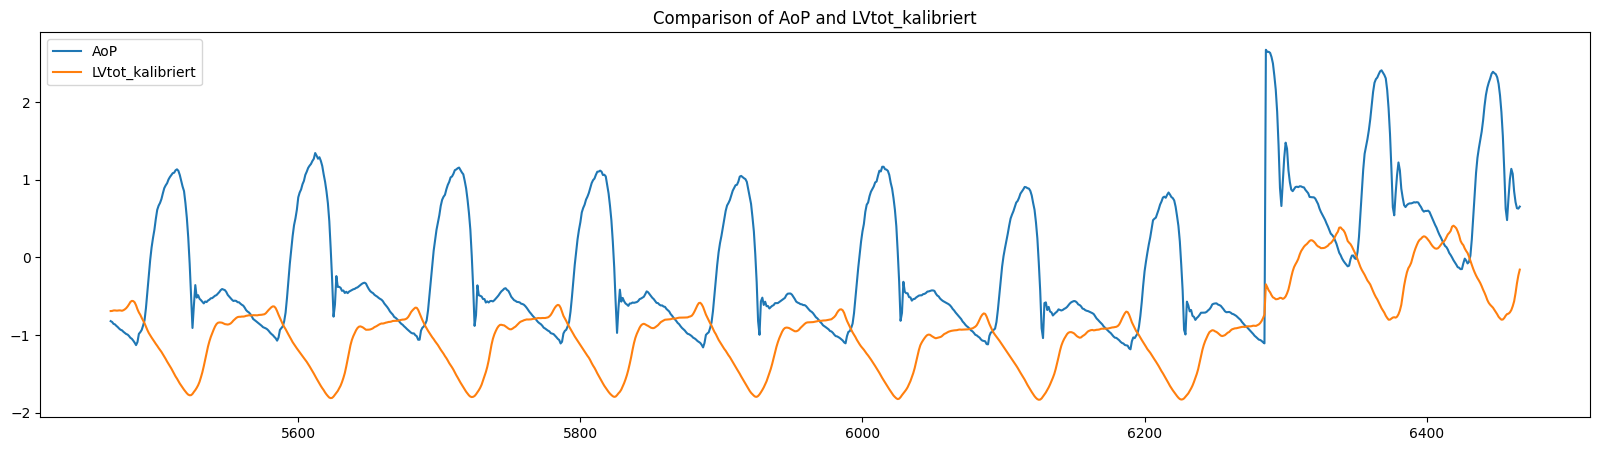

In [41]:
plt.figure(figsize=(20, 5))
plt.plot(df_train[SIG_A][5000:6000], label= SIG_A)
plt.plot(df_train[SIG_B][5000:6000], label= SIG_B)
plt.title('Comparison of {} and {}'.format(SIG_A, SIG_B))
plt.legend()
plt.show()

In [42]:
# initialize generator and discriminator
gen_A = UnetGenerator().to(DEVICE)
gen_B = UnetGenerator().to(DEVICE)
disc_A = AP_Discriminator().to(DEVICE)
disc_B = AP_Discriminator().to(DEVICE)

# optimizers for discriminator and generator 
opt_disc = torch.optim.AdamW(                                         
    list(disc_A.parameters()) + list(disc_B.parameters()), 
    lr=LEARNING_RATE, 
)
opt_gen = torch.optim.AdamW(
    list(gen_A.parameters()) + list(gen_B.parameters()),
    lr=LEARNING_RATE,
)


# maybe a step learning rate would be a good idea 1e-5 -> 1e-4
# scheduler
gen_scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer = opt_gen,
                                                      total_iters = NUM_EPOCHS-LR_DECAY_AFTER_EPOCH, 
                                                      power = 1,
                                                    )
disc_scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer = opt_disc,
                                                       total_iters = NUM_EPOCHS-LR_DECAY_AFTER_EPOCH, 
                                                       power = 1,
                                                    )

l1 = nn.L1Loss() # L1 loss for cycle consistency and identity loss
mse = nn.MSELoss() # MSE loss for adversarial loss

# create datasets with class SignalDataset
dataset = TestDataset(signal_A=SIG_A, signal_B=SIG_B, df=df_train)
test_dataset = TestDataset(signal_A=SIG_A, signal_B=SIG_B, df=df_test)
gen_dataset = TestDataset(signal_A=SIG_A, signal_B=SIG_B, df=df_gen)  

# Data loader
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True,)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True,)
gen_loader = DataLoader(gen_dataset, batch_size=1, shuffle=True, pin_memory=True,)

# run in float16
g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()

train_losses = {
            'Discrminator A loss' : [],
            'Discrminator B loss' : [],
            'Total Discrminator loss' : [],
            'Adversaral loss A' : [],
            'Adversaral loss B' : [],
            'Cycle consistency loss A' : [],
            'Cycle consistency loss B' : [],
            'Total Generator loss' : [],
        }

test_losses = {
            'Discrminator A loss' : [],
            'Discrminator B loss' : [],
            'Total Discrminator loss' : [],
            'Adversaral loss A' : [],
            'Adversaral loss B' : [],
            'Cycle consistency loss A' : [],
            'Cycle consistency loss B' : [],
            'Total Generator loss' : [],
            'L1 loss between real signal A and fake signals A' : [],
            'L1 loss between real signal B and fake signals B' : [],
        }

B_reals = 0
B_fakes = 0

100%|██████████| 1000/1000 [04:15<00:00,  3.91it/s]

Generate fake signals


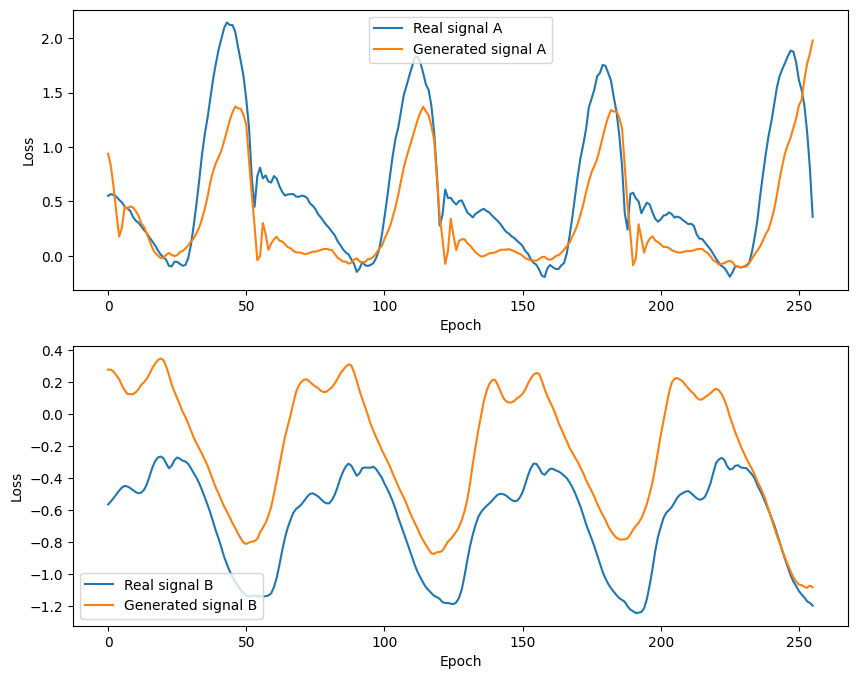

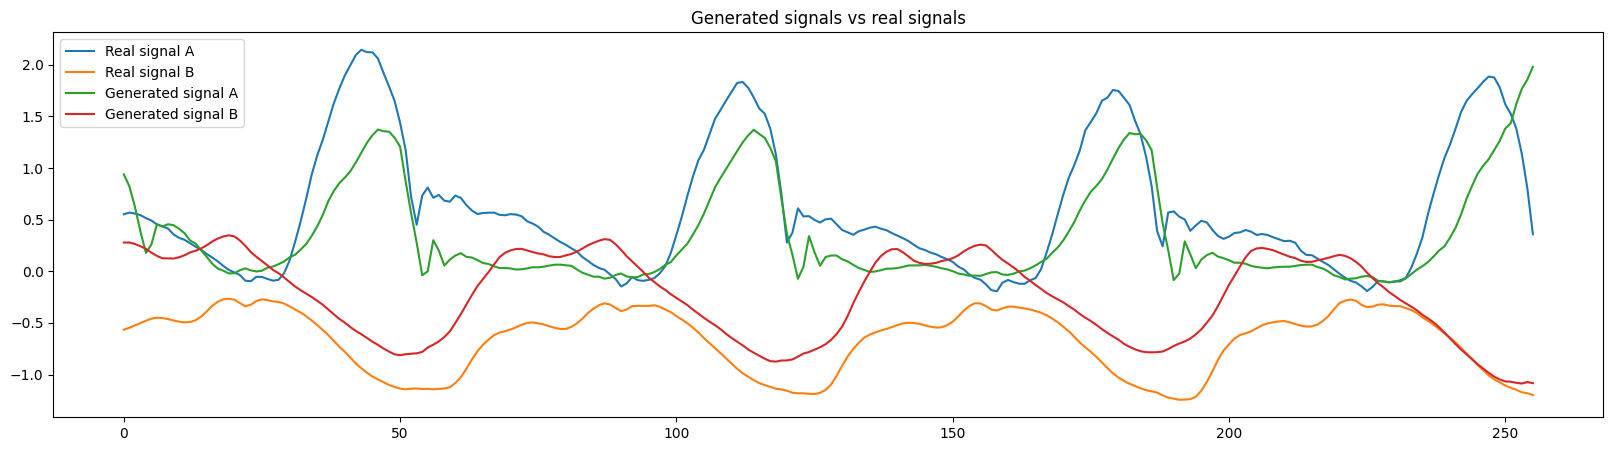

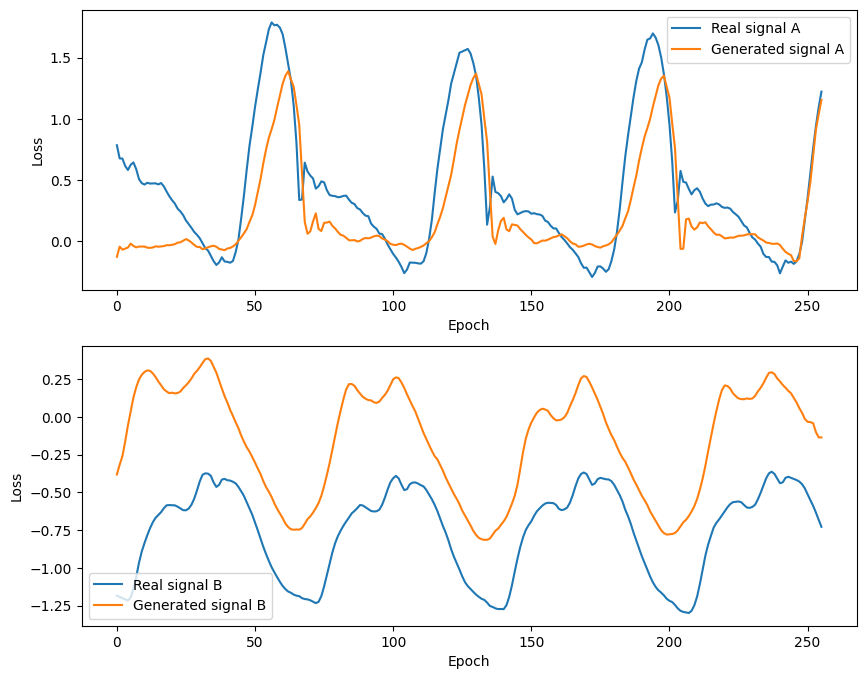

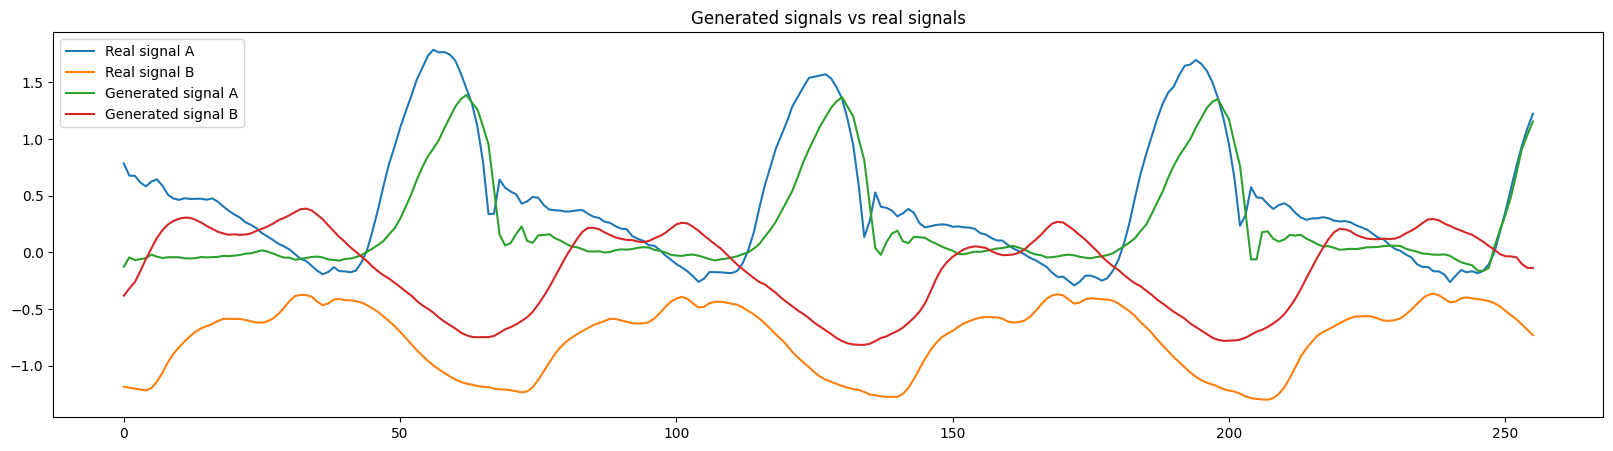

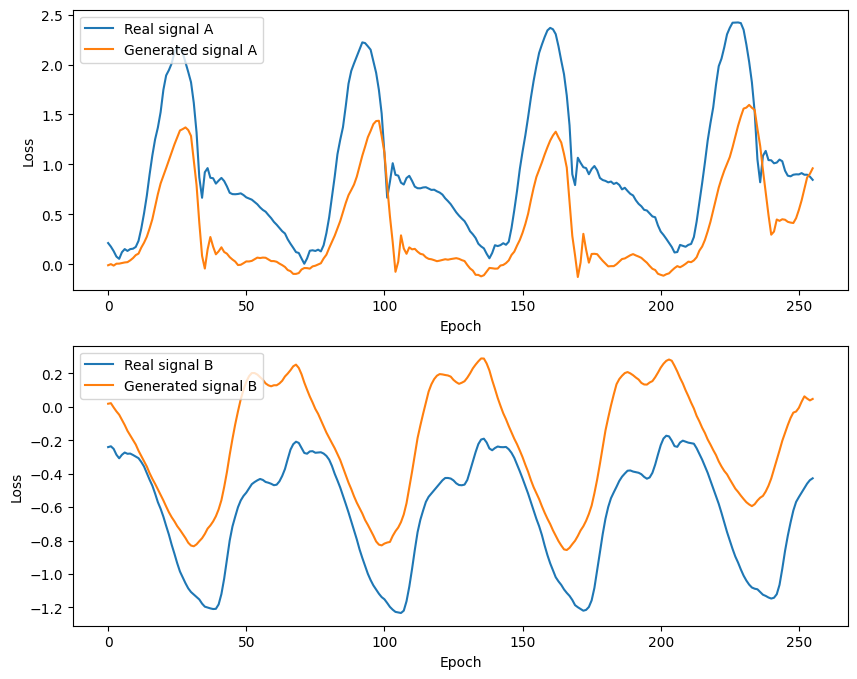

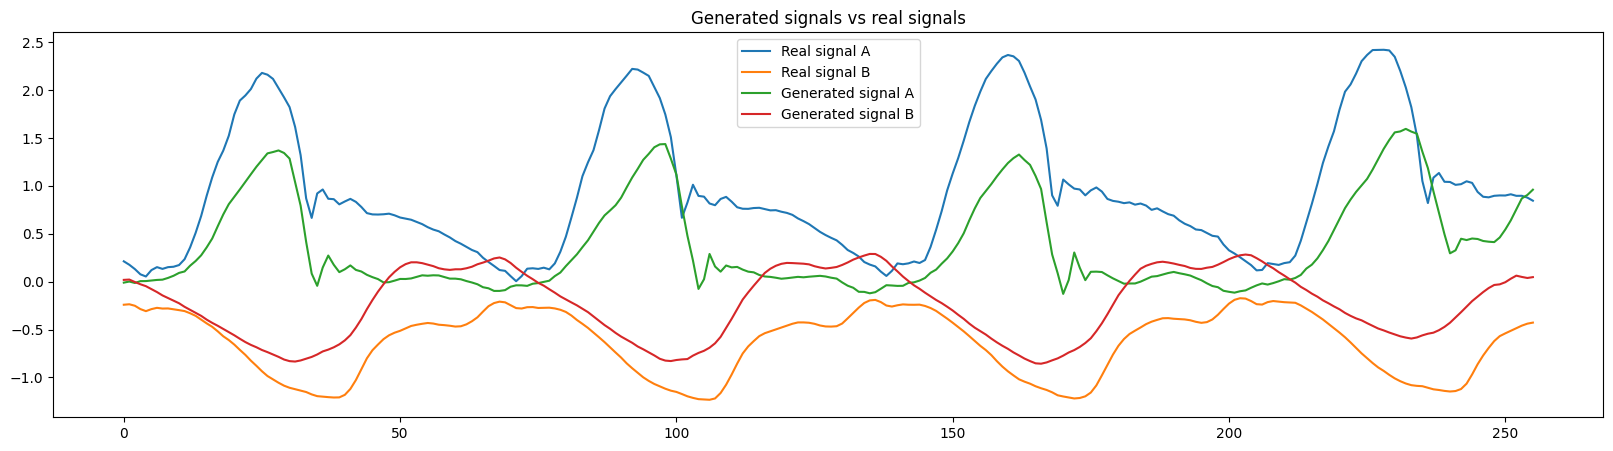

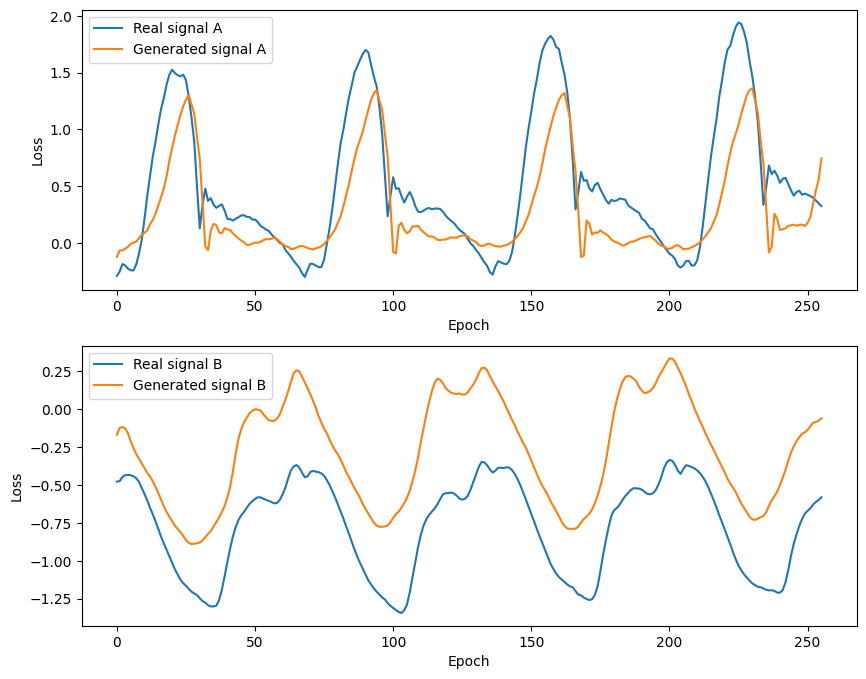

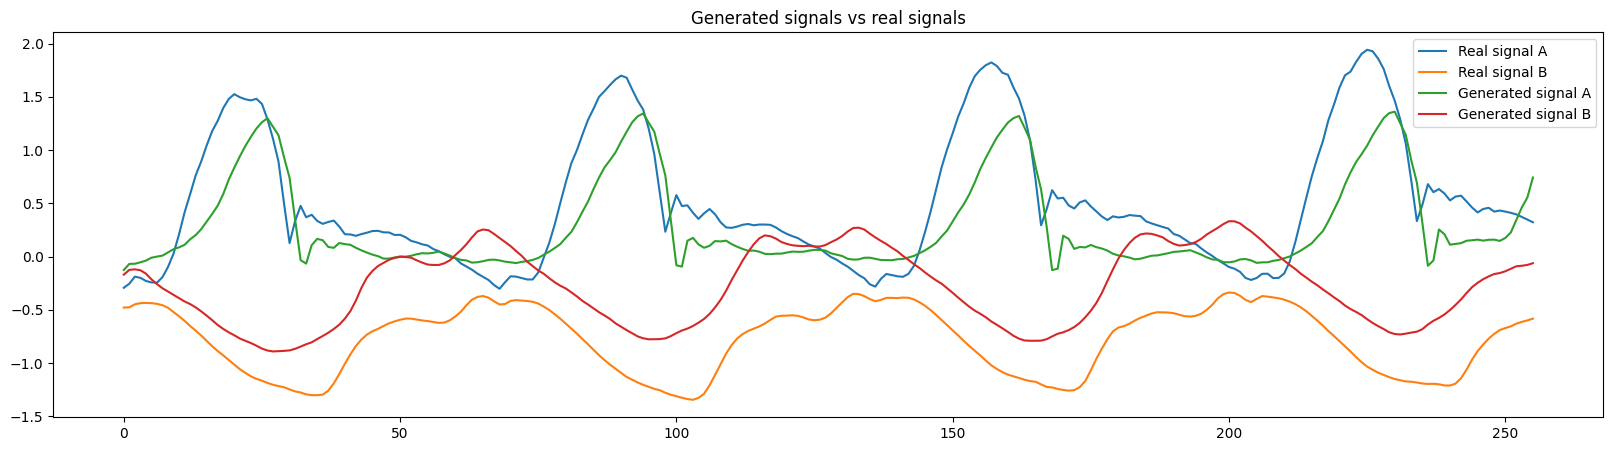

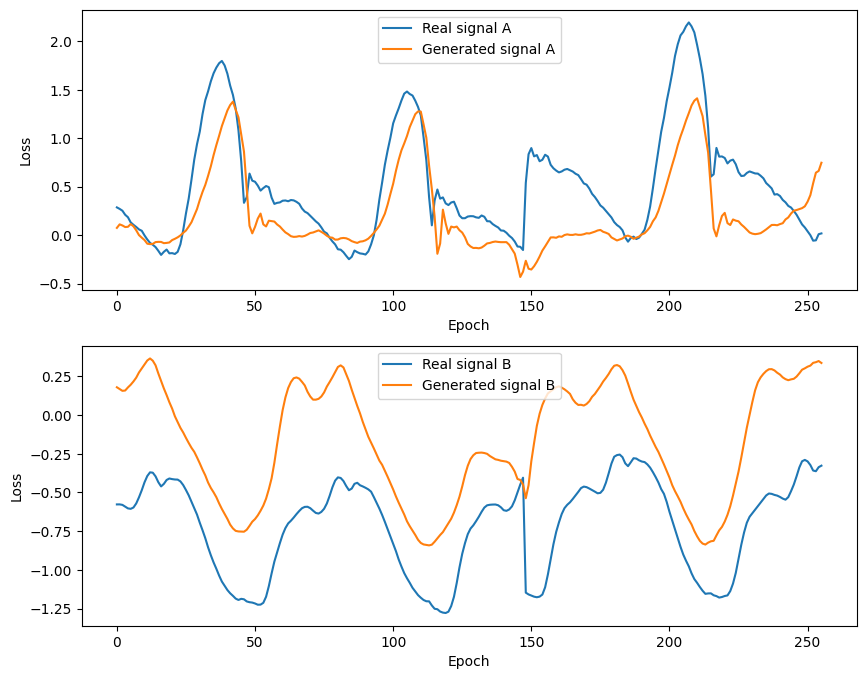

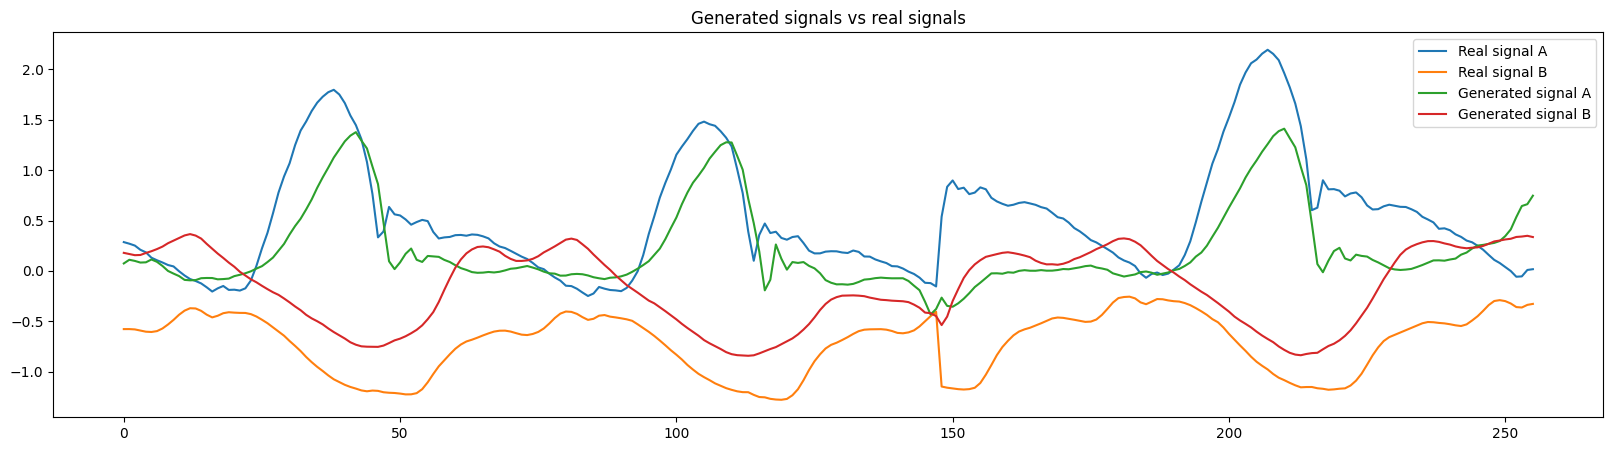

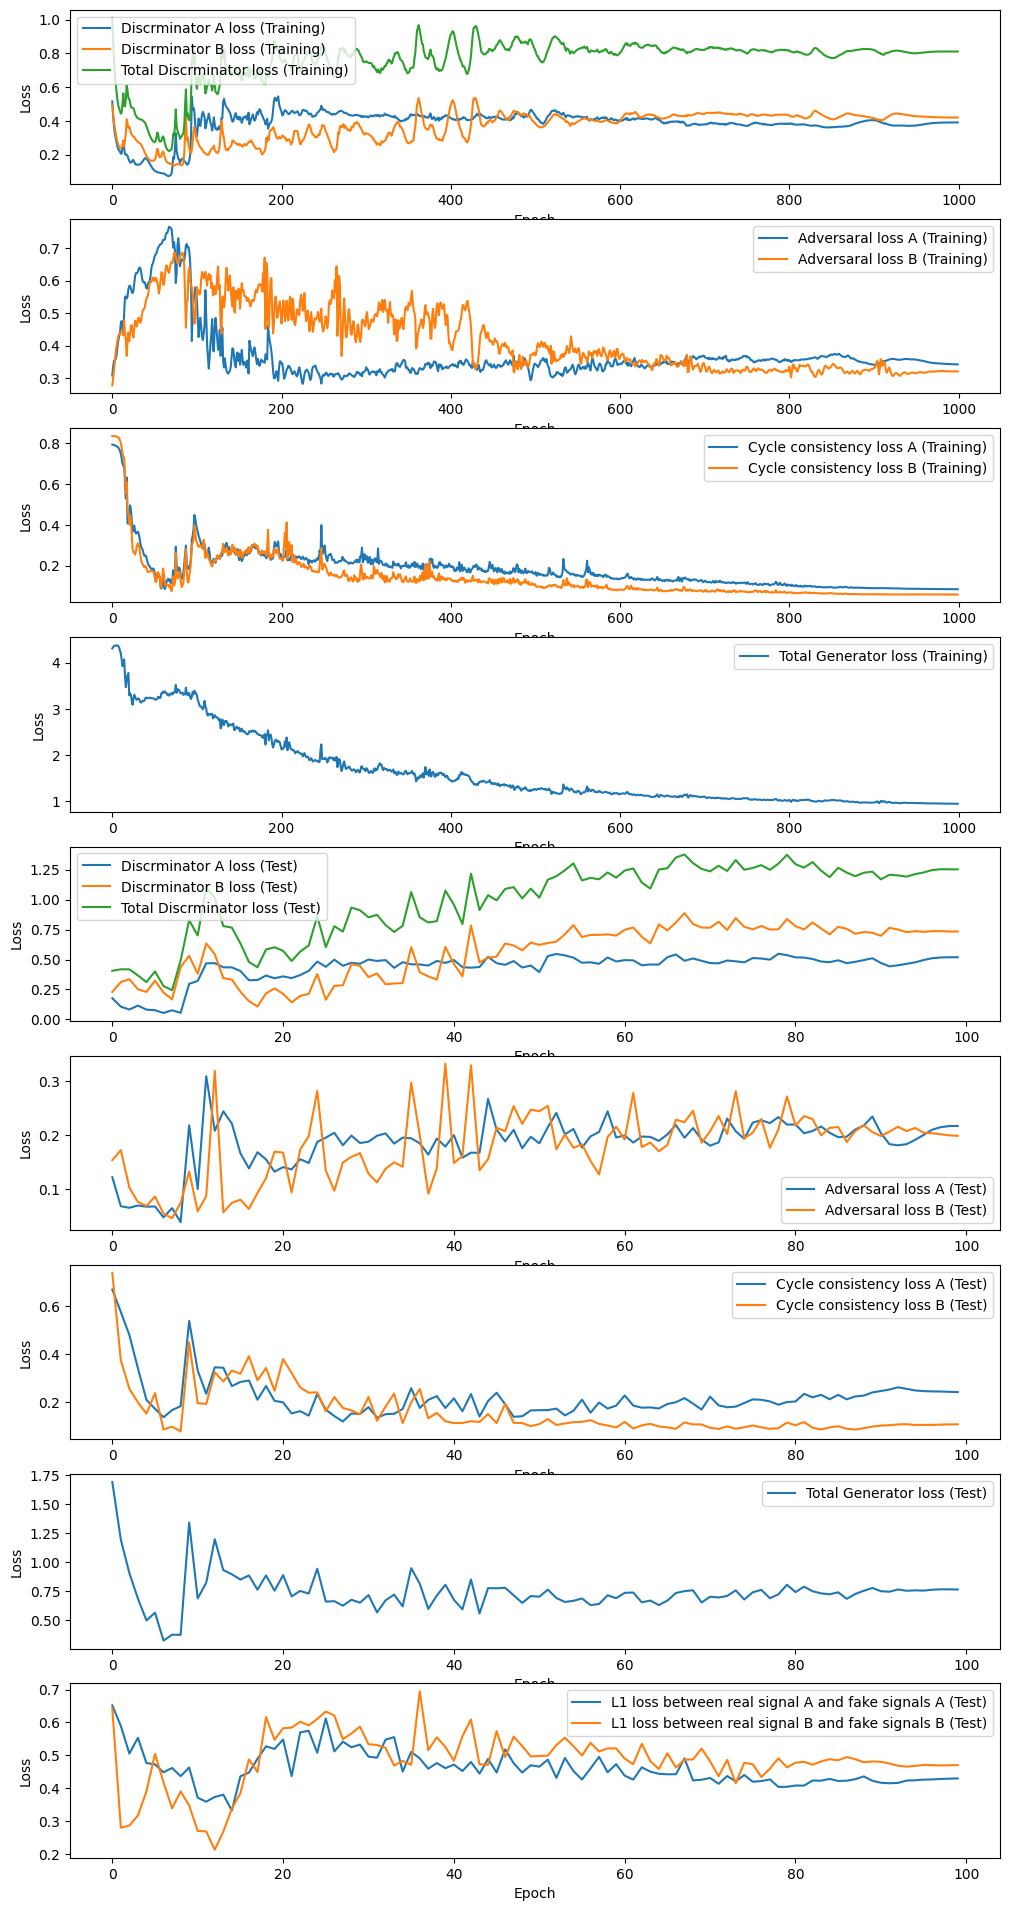

Selected losses for the test dataset after the last epoch:


L1 loss between real signal A and fake signals A:  0.4295615553855896

L1 loss between real signal B and fake signals B:  0.4700879156589508

Discrminator A loss:  0.5189833045005798

Discrminator B loss:  0.7335646748542786

Total Discriminator loss:  1.2525479793548584

Adversaral loss A:  0.2168460637331009

Adversaral loss B:  0.19864700734615326

Cycle consistency loss A:  0.24241484701633453

Cycle consistency loss B:  0.107429139316082

Total Generator loss:  0.7653370499610901
Training finished


In [43]:
# training loop
from tqdm.auto import tqdm

for epoch in tqdm(range(NUM_EPOCHS)):

    for sig_A, sig_B in loader:
        # convert to float16
        sig_A = sig_A.float() # neccessary to prevent error: "Input type (torch.cuda.DoubleTensor) 
        sig_B = sig_B.float() # and weight type (torch.cuda.HalfTensor) should be the same"
    
        # move to GPU
        sig_A = sig_A.to(DEVICE)
        sig_B = sig_B.to(DEVICE)

        #  -------------------------------- #
        #  ----- train discriminators ----- #
        #  -------------------------------- #
        with torch.cuda.amp.autocast(): # necessary for float16

            fake_B = gen_B(sig_A) # generate fake signal B
            d_B_real = disc_B(sig_B) # output of discriminator B for real signal B
            d_B_fake = disc_B(fake_B.detach()) # output of discriminator B for fake signal B (detached from generator)

            # B_reals += d_B_real.mean().item()
            # B_fakes += d_B_fake.mean().item()

            # Loss between dicriminator (with real signal) output and 1 - The discriminator should output 1 for real signals
            d_B_real_loss = mse(d_B_real, torch.ones_like(d_B_real))  
            # Loss between dicriminator (with fake signal) output and 0 - The discriminator should output 0 for fake signals
            d_B_fake_loss = mse(d_B_fake, torch.zeros_like(d_B_fake)) 
            # Total loss for discriminator B
            d_B_loss = d_B_real_loss + d_B_fake_loss

            fake_A = gen_A(sig_B)
            d_A_real = disc_A(sig_A)
            d_A_fake = disc_A(fake_A.detach()) 
            d_A_real_loss = mse(d_A_real, torch.ones_like(d_A_real)) 
            d_A_fake_loss = mse(d_A_fake, torch.zeros_like(d_A_fake))  
            d_A_loss = d_A_real_loss + d_A_fake_loss

            # Total loss for discriminator A
            d_loss = d_A_loss + d_B_loss  # in cycle GAN paper they halve the loss

        # exit amp.auto_cast() context manager and backpropagate 
        opt_disc.zero_grad() 
        d_scaler.scale(d_loss).backward()  
        d_scaler.step(opt_disc)  
        d_scaler.update()
        

        # -------------------------------- #
        # ------- train generators ------- #
        # -------------------------------- # 
        with torch.cuda.amp.autocast():

            # ----- adversarial loss for both generators ----- #
            d_A_fake = disc_A(fake_A) # disc_A should output 0 for fake signal A
            d_B_fake = disc_B(fake_B) # disc_B should output 0 for fake signal B
            # loss between discriminator output and 0 - The discriminator should output 0 for fake signals
            g_A_loss = mse(d_A_fake, torch.ones_like(d_A_fake)) # was ones_like before  
            g_B_loss = mse(d_B_fake, torch.ones_like(d_B_fake)) # was ones_like before

            # supervised A loss
            sup_A_loss = mse(sig_A, fake_A)
            sup_B_loss = mse(sig_B, fake_B)

            # ----- cycle consistency loss ----- #
            cycle_B = gen_B(fake_A) # fake_A = gen_A(sig_B)  
            cycle_A = gen_A(fake_B) # fake_B = gen_B(sig_A)
            cycle_B_loss = l1(sig_B, cycle_B)  # l1 loss: Mean absolute error between each element in the input x and target y.
            cycle_A_loss = l1(sig_A, cycle_A)

            # ----- identity loss ----- #
            #id_B = gen_B(sig_B) 
            #id_A = gen_A(sig_A)
            #id_B_loss = l1(sig_B, id_B)
            #id_A_loss = l1(sig_A, id_A)

            # put it all together
            g_loss = (
                g_A_loss +
                g_B_loss +
                cycle_B_loss * LAMBDA_CYCLE +
                cycle_A_loss * LAMBDA_CYCLE  +
                sup_A_loss * LAMBDA_SUPERVISED +
                sup_B_loss * LAMBDA_SUPERVISED
                # + id_B_loss * LAMBDA_IDENTITY +  # LAMBDA_IDENTITY = 0.0 -> no identity loss 
                # id_A_loss * LAMBDA_IDENTITY    # we could remove it to increase training speed
            )

        # update gradients of generator
        opt_gen.zero_grad()
        g_scaler.scale(g_loss).backward() 
        g_scaler.step(opt_gen) 
        g_scaler.update()

    # save losses
    train_losses['Discrminator A loss'].append(d_A_loss.item())
    train_losses['Discrminator B loss'].append(d_B_loss.item())
    train_losses['Total Discrminator loss'].append(d_loss.item())
    train_losses['Adversaral loss A'].append(g_A_loss.item())
    train_losses['Adversaral loss B'].append(g_B_loss.item())
    train_losses['Cycle consistency loss A'].append(cycle_A_loss.item())
    train_losses['Cycle consistency loss B'].append(cycle_B_loss.item())
    train_losses['Total Generator loss'].append(g_loss.item())
    #train_losses['Identity loss A'].append(id_A_loss.item())
    #train_losses['Identity loss B'].append(id_B_loss.item())
    

    # ------------------------ #
    # ------ Validation ------ #
    # ------------------------ #

    #  validation every 10 epochs
    if (epoch+1) % 10 == 0:

        with torch.no_grad():
            # set models to evaluation mode
            disc_A.eval()  # set discriminator to evaluation mode
            disc_B.eval()  # turns off Dropouts Layers, BatchNorm Layers etc
            gen_B.eval()
            gen_A.eval()

            # store losses for testing
            test_Discrminator_A_loss = 0 #
            test_Discrminator_B_loss = 0 #
            test_Total_Discrminator_loss = 0 #
            test_Adversaral_loss_A = 0  #
            test_Adversaral_loss_B = 0  #
            test_Cycle_consistency_loss_A = 0 #
            test_Cycle_consistency_loss_B = 0 #
            test_Total_Generator_loss = 0 #
            test_L1_real_fake_A = 0  # L1 loss between real signal A and fake signal A
            test_L1_real_fake_B = 0  # L1 loss between real signal B and fake signal B

            for sig_A, sig_B in test_loader:
                # convert to float16
                sig_A = sig_A.float()
                sig_B = sig_B.float()

                # move to GPU
                sig_A = sig_A.to(DEVICE)
                sig_B = sig_B.to(DEVICE)

                fake_B = gen_B(sig_A)
                fake_A = gen_A(sig_B)
        
                # calculate l1 loss of fake signals and real signals
                test_L1_real_fake_B = l1(sig_B, fake_B)   # l1(sig_B, fake_B)
                test_L1_real_fake_A = l1(sig_A, fake_A)   # l1(sig_A, fake_A)

                # calculate adversarial loss
                test_Adversaral_loss_B = mse(disc_B(fake_B), torch.zeros_like(disc_B(fake_B))) #was ones_like before
                test_Adversaral_loss_A = mse(disc_A(fake_A), torch.zeros_like(disc_A(fake_A)))

                # ----- cycle loss ----- #
                cycle_B = gen_B(fake_A)  # fake_A = gen_B2A(sig_B)
                cycle_A = gen_A(fake_B)  # fake_B = gen_A2B(sig_A)
                test_Cycle_consistency_loss_B = l1(sig_B, cycle_B)
                test_Cycle_consistency_loss_A = l1(sig_A, cycle_A)

                # ----- identity loss ----- #
                # I am not tracking the identity loss because it is 0
                #id_B = gen_B(sig_B)
                #id_A = gen_A(sig_A)
                #id_B_loss = l1(sig_B, id_B)
                #id_A_loss = l1(sig_A, id_A)

                # ----- discriminator loss ----- #
                test_Discrminator_A_loss = mse(disc_A(sig_A), torch.ones_like(disc_A(sig_A))) + mse(disc_A(fake_A), torch.zeros_like(disc_A(fake_A)))
                test_Discrminator_B_loss = mse(disc_B(sig_B), torch.ones_like(disc_B(sig_B))) + mse(disc_B(fake_B), torch.zeros_like(disc_B(fake_B)))
                
                # ----- total generator loss ----- #
                test_Total_Generator_loss = test_Adversaral_loss_A + test_Adversaral_loss_B + test_Cycle_consistency_loss_B + test_Cycle_consistency_loss_A 
                
                # ----- total discriminator loss ----- #
                test_Total_Discrminator_loss = test_Discrminator_A_loss + test_Discrminator_B_loss

                # save losses
                test_losses['Discrminator A loss'].append(test_Discrminator_A_loss.item())
                test_losses['Discrminator B loss'].append(test_Discrminator_B_loss.item())
                test_losses['Total Discrminator loss'].append(test_Total_Discrminator_loss.item())
                test_losses['Adversaral loss A'].append(test_Adversaral_loss_A.item())
                test_losses['Adversaral loss B'].append(test_Adversaral_loss_B.item())
                test_losses['Cycle consistency loss A'].append(test_Cycle_consistency_loss_A.item())
                test_losses['Cycle consistency loss B'].append(test_Cycle_consistency_loss_B.item())
                test_losses['Total Generator loss'].append(test_Total_Generator_loss.item())
                test_losses['L1 loss between real signal A and fake signals A'].append(test_L1_real_fake_A.item())
                test_losses['L1 loss between real signal B and fake signals B'].append(test_L1_real_fake_B.item())


            #  ------------------------------------- #   
            #  ------- Generate fake signals ------- #
            #  ------------------------------------- #
            
            # Generate fake signals after the last epoch
            
            if (epoch+1) % GENERATION_AFTER_EPOCH == 0:
                print('Generate fake signals')
                # generate fake signals 10 times
                #utils.save_predictions(gen_loader, gen_B, gen_A, fake_A, fake_B, DEVICE, mse)
                idx =0
                for sig_A, sig_B in gen_loader:
                    if idx == 5:
                        break

                    sig_A = sig_A.float()
                    sig_B = sig_B.float()
                    sig_A = sig_A.to(DEVICE)
                    sig_B = sig_B.to(DEVICE)

                    fake_B = gen_B(sig_A)
                    fake_A = gen_A(sig_B)

                    # plot generated signals and real signals
                    #reshape to 1D
                    fake_B = fake_B.reshape(-1)
                    fake_A = fake_A.reshape(-1)
                    sig_A = sig_A.reshape(-1)
                    sig_B = sig_B.reshape(-1)

                    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
                    ax[0].plot(sig_A.cpu().numpy(), label= 'Real signal A')
                    ax[0].plot(fake_A.cpu().numpy(), label= 'Generated signal A')
                    ax[0].set_xlabel('Epoch')
                    ax[0].set_ylabel('Loss')
                    ax[0].legend()

                    ax[1].plot(sig_B.cpu().numpy(), label= 'Real signal B')
                    ax[1].plot(fake_B.cpu().numpy(), label= 'Generated signal B')
                    ax[1].set_xlabel('Epoch')
                    ax[1].set_ylabel('Loss')
                    ax[1].legend()

                    # plot generated signals and real signals
                    plt.figure(figsize=(20, 5))
                    plt.plot(sig_A.cpu().detach().numpy(), label= 'Real signal A')
                    plt.plot(sig_B.cpu().detach().numpy(), label= 'Real signal B')
                    plt.plot(fake_A.cpu().detach().numpy(), label= 'Generated signal A')
                    plt.plot(fake_B.cpu().detach().numpy(), label= 'Generated signal B')
                    plt.title('Generated signals vs real signals')
                    plt.legend()

                    idx += 1
                        
                # save generated signals
                # utils.save_predictions(test_loader, gen_A, gen_B,  DEVICE)

        # activate training mode again
        disc_A.train()  
        disc_B.train()
        gen_B.train()
        gen_A.train()

    # scheduler step if epoch > LR_DECAY_AFTER_EPOCH
    if (epoch+1) >= LR_DECAY_AFTER_EPOCH:
        disc_scheduler.step()
        gen_scheduler.step()
        
# ----------------------------------- #
# -------------- PLOT --------------- #
# ----------------------------------- #

# Plot training losses in different subplots

fig, ax = plt.subplots(9, 1, figsize=(12, 24))
ax[0].plot(train_losses['Discrminator A loss'], label= 'Discrminator A loss (Training)')
ax[0].plot(train_losses['Discrminator B loss'], label= 'Discrminator B loss (Training)')
ax[0].plot(train_losses['Total Discrminator loss'], label= 'Total Discrminator loss (Training)')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
#ax[0].set_title('Training Discriminator Loss')

ax[1].plot(train_losses['Adversaral loss A'], label= 'Adversaral loss A (Training)')
ax[1].plot(train_losses['Adversaral loss B'], label= 'Adversaral loss B (Training)')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
#ax[1].set_title('Training Adversarial Loss')
ax[2].plot(train_losses['Cycle consistency loss A'], label= 'Cycle consistency loss A (Training)')
ax[2].plot(train_losses['Cycle consistency loss B'], label= 'Cycle consistency loss B (Training)')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Loss')
ax[2].legend()
#ax[2].set_title('Training Cycle Consistency Loss')
ax[3].plot(train_losses['Total Generator loss'], label= 'Total Generator loss (Training)')
ax[3].set_xlabel('Epoch')
ax[3].set_ylabel('Loss')
ax[3].legend()
#ax[3].set_title('Training Total Generator Loss')

# Plot test losses in different subplots

ax[4].plot(test_losses['Discrminator A loss'], label= 'Discrminator A loss (Test)')
ax[4].plot(test_losses['Discrminator B loss'], label= 'Discrminator B loss (Test)')
ax[4].plot(test_losses['Total Discrminator loss'], label= 'Total Discrminator loss (Test)')
ax[4].set_xlabel('Epoch')
ax[4].set_ylabel('Loss')
ax[4].legend()
#ax[4].set_title('Test Discriminator Loss')

ax[5].plot(test_losses['Adversaral loss A'], label= 'Adversaral loss A (Test)')
ax[5].plot(test_losses['Adversaral loss B'], label= 'Adversaral loss B (Test)')
ax[5].set_xlabel('Epoch')
ax[5].set_ylabel('Loss')
ax[5].legend()
#ax[5].set_title('Test Adversarial Loss')

ax[6].plot(test_losses['Cycle consistency loss A'], label= 'Cycle consistency loss A (Test)')
ax[6].plot(test_losses['Cycle consistency loss B'], label= 'Cycle consistency loss B (Test)')
ax[6].set_xlabel('Epoch')
ax[6].set_ylabel('Loss')
ax[6].legend()
#ax[6].set_title('Test Cycle Consistency Loss')

ax[7].plot(test_losses['Total Generator loss'], label= 'Total Generator loss (Test)')
ax[7].set_xlabel('Epoch')
ax[7].set_ylabel('Loss')
ax[7].legend()
#ax[7].set_title('Test Total Generator Loss')

ax[8].plot(test_losses['L1 loss between real signal A and fake signals A'], label= 'L1 loss between real signal A and fake signals A (Test)')
ax[8].plot(test_losses['L1 loss between real signal B and fake signals B'], label= 'L1 loss between real signal B and fake signals B (Test)')
ax[8].set_xlabel('Epoch')
ax[8].set_ylabel('Loss')
ax[8].legend()
#ax[8].set_title('Test L1 Loss')

plt.show()

print('Selected losses for the test dataset after the last epoch:\n')
print('\nL1 loss between real signal A and fake signals A: ', test_losses['L1 loss between real signal A and fake signals A'][-1])
print('\nL1 loss between real signal B and fake signals B: ', test_losses['L1 loss between real signal B and fake signals B'][-1])
print('\nDiscrminator A loss: ', test_losses['Discrminator A loss'][-1])
print('\nDiscrminator B loss: ', test_losses['Discrminator B loss'][-1])
print('\nTotal Discriminator loss: ', test_losses['Total Discrminator loss'][-1])
print('\nAdversaral loss A: ', test_losses['Adversaral loss A'][-1])
print('\nAdversaral loss B: ', test_losses['Adversaral loss B'][-1])
print('\nCycle consistency loss A: ', test_losses['Cycle consistency loss A'][-1])
print('\nCycle consistency loss B: ', test_losses['Cycle consistency loss B'][-1])
print('\nTotal Generator loss: ', test_losses['Total Generator loss'][-1])


print('Training finished')

Selected losses for the test dataset after the last epoch:  l1 loss is compared between fake A and real B


L1 loss between real signal A and fake signals A:  1.0840096473693848

L1 loss between real signal B and fake signals B:  0.7750750780105591

Discrminator A loss:  0.000545856892131269

Discrminator B loss:  5.888868690817617e-05

Total Discriminator loss:  0.000604745582677424

Adversaral loss A:  0.0005234883283264935

Adversaral loss B:  3.158558320137672e-05

Cycle consistency loss A:  0.016748687252402306

Cycle consistency loss B:  0.007062472868710756

Total Generator loss:  0.024366233497858047
Training finished

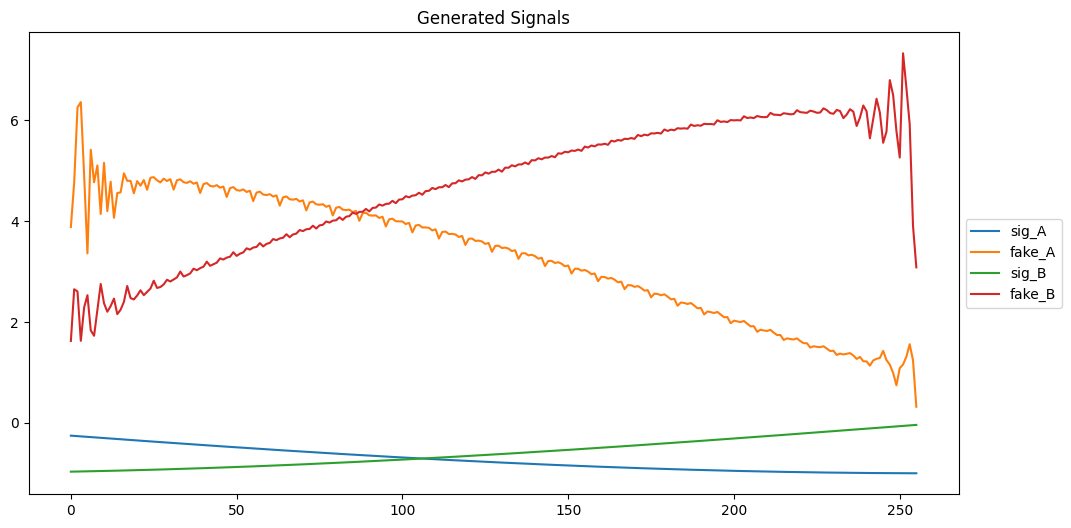

In [44]:
# load csv
df = pd.read_csv('generated_signals.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)

# plot df
df.plot(figsize=(12, 6), title='Generated Signals')
# legend
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))


# save plot
plt.savefig('{}_to_{}.png'.format(SIG_A, SIG_B), bbox_inches='tight')

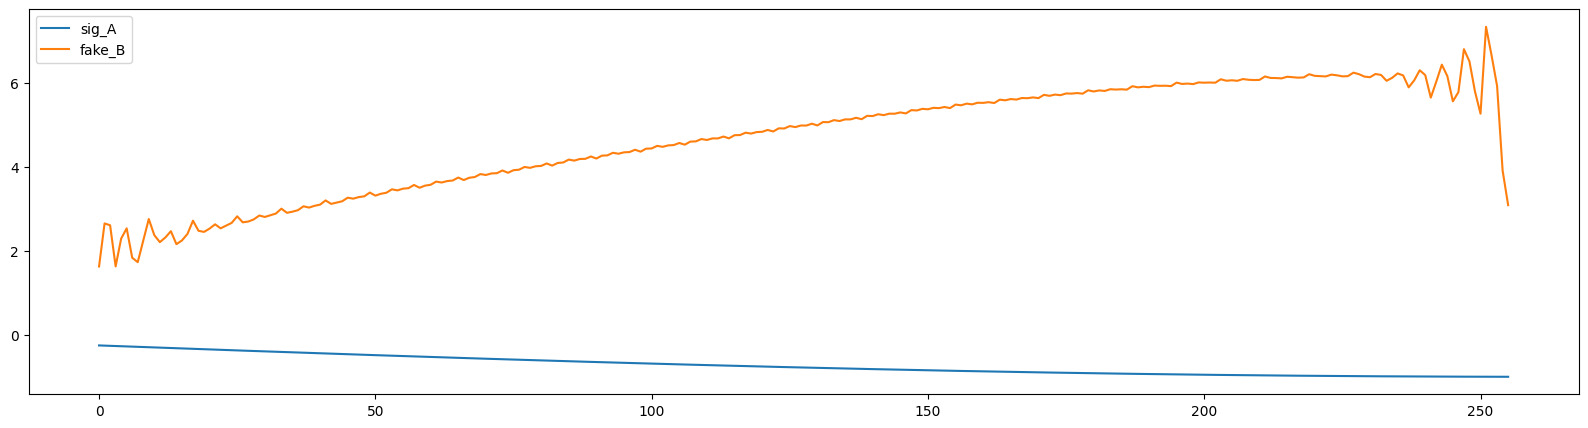

In [45]:
# load csv
df = pd.read_csv('generated_signals.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)

plt.figure(figsize=(20, 5))
plt.plot(df['sig_A'], label= 'sig_A')
plt.plot(df['fake_B'], label= 'fake_B')
plt.legend()
plt.show()